# 1️⃣ Large DataSet of Real Data - No preprocessing 
- Data size is 10k
- Real data from MADAR dataset randomly sampled
- No preprocessing because seems to decrease accruacy and F1-score

# Semi-Supervised Learning (Self-Training) reverse 🔀

* Semi-Supervised Learning combines labeled and unlabeled examples
* In self-Training, you could convert a Supervised Machine Learning algorithm to a semi-supervised one

### **Steps** ✨
1. Train supervised model using labeled data
2. Make predictions on unlabeled data using the model from the previous step
3. Take predictions satisfying probability threshold criteria and add them to the pseudo-labeled set
4. combine the labeled and pseudo-labeled data and train the next verion of the model
5. Make predictions on the remaining unlabeled data using this model of step 4
6. Take predictions satisfying the probability threshold and add them to an existing pseudo-labeled set

### **References:** 🔗
* https://www.kaggle.com/code/sasakitetsuya/semi-supervised-classification-on-a-text-dataset 
* https://scikit-learn.ru/example/semi-supervised-classification-on-a-text-dataset/


## Importing 

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/larger-dialects/Arabic_dialects_Larger.csv
/kaggle/input/arabic-real-data-dialects/Arabic_dialects.csv


In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
#==============================================different Linear classifiers
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, RidgeClassifier
from sklearn.svm import LinearSVC
#=====================================================
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import re
import nltk
from nltk.corpus import stopwords

In [3]:
data=pd.read_csv('/kaggle/input/larger-dialects/Arabic_dialects_Larger.csv')

## Data Preprocessing

In [4]:
data.head()

,sentID.BTEC,split,lang,sent,label
0,2100,corpus-6-test-corpus-26-test,BAS,باك محفظتي وشرد.,Iraqi
1,10182,corpus-6-test-corpus-26-train,JED,منظر حلو. دي ممرات مشاة حلوة.,Gulf
2,16292,corpus-6-test-corpus-26-test,ALG,تقدر تديني لكانترباري و ترجعني؟,Maghrebi
3,412,corpus-6-train,DOH,هذي هدية. ممكن تغلفها؟,Gulf
4,9431,corpus-6-test-corpus-26-train,MUS,اهني واحده لك سيدي.,Gulf


In [5]:
data.split.unique()

array(['corpus-6-test-corpus-26-test', 'corpus-6-test-corpus-26-train',
       'corpus-6-train', 'corpus-6-test-corpus-26-dev', 'corpus-6-dev'],
      dtype=object)

In [6]:
data.columns

Index(['sentID.BTEC', 'split', 'lang', 'sent', 'label'], dtype='object')

In [7]:
data.drop(['sentID.BTEC', 'split', 'lang'], axis=1)

,sent,label
0,باك محفظتي وشرد.,Iraqi
1,منظر حلو. دي ممرات مشاة حلوة.,Gulf
2,تقدر تديني لكانترباري و ترجعني؟,Maghrebi
3,هذي هدية. ممكن تغلفها؟,Gulf
4,اهني واحده لك سيدي.,Gulf
...,...,...
10002,أبا بطارية.,Gulf
10003,باقي شكلها اخضر.,Gulf
10004,أبا امسحه.,Gulf
10005,هو جنب غرفة الامانات.,Levantine


In [8]:
label_counts = data['label'].value_counts()

In [9]:
label_counts

label
Levantine    2004
Iraqi        2001
Maghrebi     2001
Egyptian     2001
Gulf         2000
Name: count, dtype: int64

## Modeling

In [10]:
sdg_params = dict(alpha=1e-5, penalty='l2', loss='log')
arabic_stop_words = [
    "و", "في", "على", "إلى", "عن", "من", "مع", "كان", "التي", "الذي", "هذا",
    "هذه", "ذلك", "تلك", "كل", "كما", "قد", "لقد", "ليس", "هو", "هي", "هم",
    "هن", "أنا", "نحن", "انت", "انتِ", "لكن", "ثم", "أو", "أيضا", "هناك",
    "هنا", "قبل", "بعد"
]
vectorizer_params = dict(
    ngram_range=(1, 5),       # 1-5 grams
    min_df=5,                 # Ignore terms that appear in fewer than 5 documents
    max_df=0.8,               # Ignore terms that appear in more than 80% of documents
    analyzer='word',          # Tokenizes at the word level (common for Arabic text)
    stop_words=arabic_stop_words  # None by default, add Arabic stop words if needed
)

In [11]:
def pipeline_creation(type_of_supervision, i, count=False):
    # Define the list of classifiers and their names
    classifiers = [
        SGDClassifier(alpha=1e-5, penalty='l2', loss='log_loss', max_iter=1000),
        LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial'),
        CalibratedClassifierCV(LinearSVC(), method='isotonic'),
        CalibratedClassifierCV(PassiveAggressiveClassifier(max_iter=1000, C=0.5), method='isotonic'),
        MultinomialNB(alpha=0.5, fit_prior=True)
    ]
    
    classifier_names = [
        "SGDClassifier",
        "LogisticRegression",
        "Calibrated LinearSVC",
        "Calibrated PassiveAggressiveClassifier",
        "MultinomialNB"
    ]
    
    if count:
        return len(classifiers)
    
    # Select classifier based on type of supervision
    elif type_of_supervision == "supervised":
        pipeline = Pipeline([
            ('vect', CountVectorizer(**vectorizer_params)),
            ('tfidf', TfidfTransformer()),
            ('clf', classifiers[i])
        ])
        return pipeline, classifier_names[i]
    
    else:  # self-supervised
        st_pipeline = Pipeline([
            ('vect', CountVectorizer(**vectorizer_params)),
            ('tfidf', TfidfTransformer()),
            ('clf', SelfTrainingClassifier(classifiers[i], verbose=True))
        ])
        return st_pipeline, f"SelfTrainingClassifier with {classifier_names[i]}"


In [12]:
def eval_and_print_metrics(clf, X_train, y_train, X_test, y_test):
    print("Number of training samples:", len(X_train))
    print("Unlabeled samples in training set:",
          sum(1 for x in y_train if x == -1))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Micro-averaged F1 score on test set: "
          "%0.3f" % f1_score(y_test, y_pred, average='micro'))
    print("-" * 10)
    print()

In [13]:
# Main code to iterate over classifiers and display results
if __name__ == "__main__":
    results = []
    # Encode labels to handle text labels properly in sklearn classifiers
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(data.label)  # Fit on full set of labels

    X = data.sent
    y = y_encoded
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
    
    # Iterate over each classifier in the pipeline
    for i in range(pipeline_creation(0, 0, True)):

        print(100 * "*")
        
        # Supervised pipeline
        pipeline, classifier_name = pipeline_creation("supervised", i)
        print(f"Supervised training on 100% of the data using {classifier_name}:")
        eval_and_print_metrics(pipeline, X_train, y_train, X_test, y_test)
        
        # Decode labels to show original values in the classification report
        y_test_decoded = label_encoder.inverse_transform(y_test)
        y_pred = pipeline.predict(X_test)
        y_pred_decoded = label_encoder.inverse_transform(y_pred)
        report = classification_report(y_test_decoded, y_pred_decoded, output_dict=True)
        print(classification_report(y_test_decoded, y_pred_decoded))
        
        # Save results for Supervised 100%
        results.append({
            'Classifier': classifier_name,
            'Setting': 'Supervised 100%',
            'Accuracy': report['accuracy'],
            'F1-Score': report['macro avg']['f1-score']
        })

        # 20% labeled data setup
        y_mask = np.random.rand(len(y_train)) < 0.2  # Random mask for 20% of the data
        X_20, y_20 = map(list, zip(*((x, y) for x, y, m in zip(X_train, y_train, y_mask) if m)))
        print(f"Supervised training on 20% of the training data using {classifier_name}:")
        eval_and_print_metrics(pipeline, X_20, y_20, X_test, y_test)

        # Decode labels for partial training classification report
        y_pred_partial = pipeline.predict(X_test)
        y_pred_partial_decoded = label_encoder.inverse_transform(y_pred_partial)
        report_partial = classification_report(y_test_decoded, y_pred_partial_decoded, output_dict=True)
        print(classification_report(y_test_decoded, y_pred_partial_decoded))

        # Save results for Supervised 20%
        results.append({
            'Classifier': classifier_name,
            'Setting': 'Supervised 20%',
            'Accuracy': report_partial['accuracy'],
            'F1-Score': report_partial['macro avg']['f1-score']
        })

        # Semi-supervised pipeline with self-training
        st_pipeline, st_classifier_name = pipeline_creation("semi-supervised", i)
        y_train_semi = np.copy(y_train)  # Copy to modify labels for self-training
        y_train_semi[~y_mask] = -1  # Unlabel the non-masked subset

        print(f"{st_classifier_name} on 20% labeled training data (rest unlabeled):")
        eval_and_print_metrics(st_pipeline, X_train, y_train_semi, X_test, y_test)

        # Decode labels for semi-supervised classification report
        y_pred_semi = st_pipeline.predict(X_test)
        y_pred_semi_decoded = label_encoder.inverse_transform(y_pred_semi)
        report_semi = classification_report(y_test_decoded, y_pred_semi_decoded, output_dict=True)
        print(classification_report(y_test_decoded, y_pred_semi_decoded))

        # Save results for Self-Training
        results.append({
            'Classifier': classifier_name,
            'Setting': 'Self-Training',
            'Accuracy': report_semi['accuracy'],
            'F1-Score': report_semi['macro avg']['f1-score']
        })


****************************************************************************************************
Supervised training on 100% of the data using SGDClassifier:
Number of training samples: 7505
Unlabeled samples in training set: 0
Micro-averaged F1 score on test set: 0.715
----------

              precision    recall  f1-score   support

    Egyptian       0.78      0.71      0.74       500
        Gulf       0.61      0.61      0.61       500
       Iraqi       0.74      0.76      0.75       500
   Levantine       0.73      0.71      0.72       501
    Maghrebi       0.72      0.78      0.75       501

    accuracy                           0.72      2502
   macro avg       0.72      0.72      0.71      2502
weighted avg       0.72      0.72      0.71      2502

Supervised training on 20% of the training data using SGDClassifier:
Number of training samples: 1491
Unlabeled samples in training set: 0
Micro-averaged F1 score on test set: 0.573
----------

              precision    rec

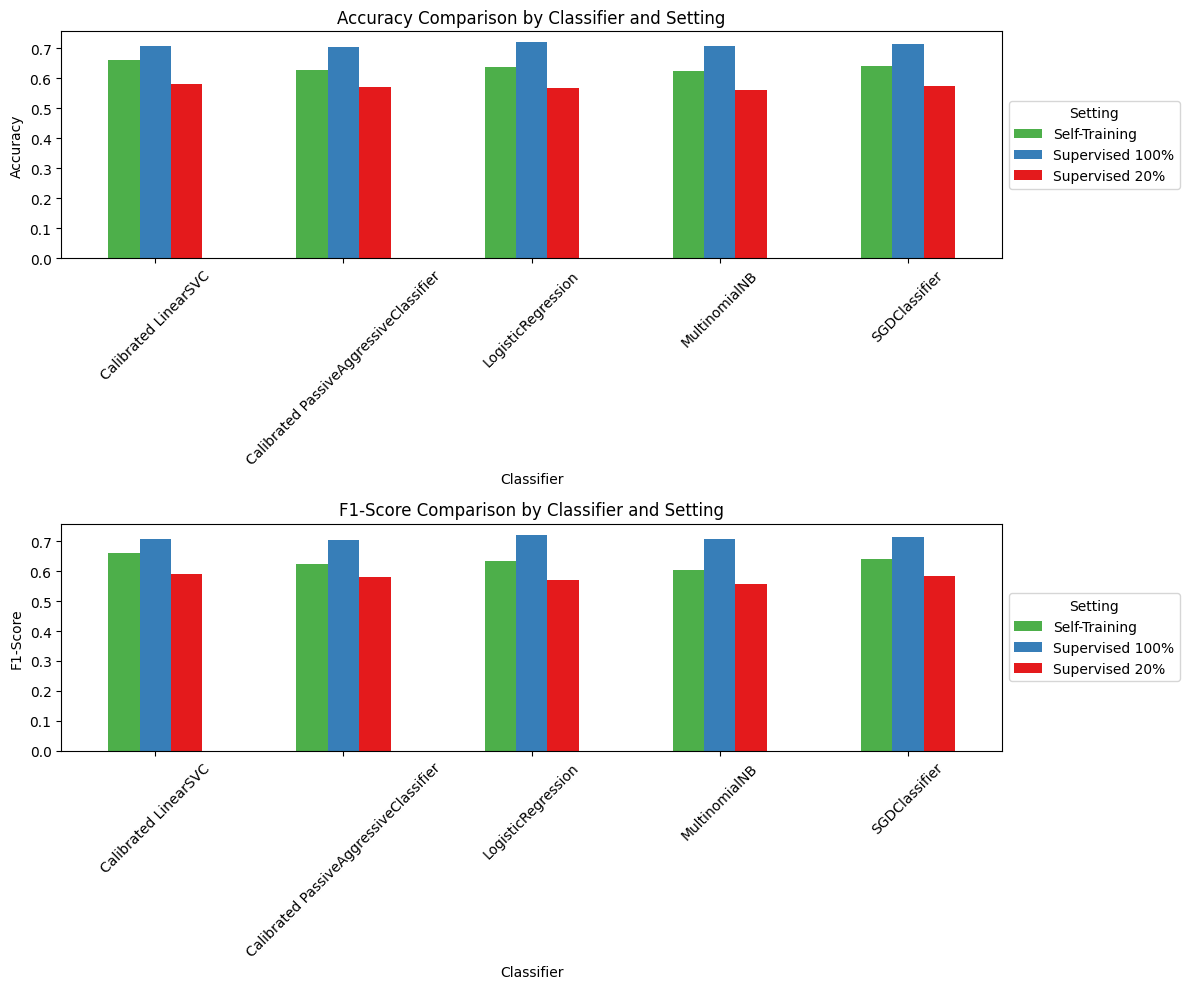

In [14]:

# Plotting
results_df = pd.DataFrame.from_dict(results)
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Accuracy plot
accuracy_df = results_df.pivot(index="Classifier", columns="Setting", values="Accuracy")
accuracy_df.plot(kind="bar", ax=axes[0], color=["#4daf4a", "#377eb8", "#e41a1c"])
axes[0].set_title("Accuracy Comparison by Classifier and Setting")
axes[0].set_ylabel("Accuracy")
axes[0].set_xlabel("Classifier")
axes[0].legend(title="Setting", loc="center left", bbox_to_anchor=(1.0, 0.5))
axes[0].tick_params(axis='x', rotation=45)

# F1-Score plot
f1_df = results_df.pivot(index="Classifier", columns="Setting", values="F1-Score")
f1_df.plot(kind="bar", ax=axes[1], color=["#4daf4a", "#377eb8", "#e41a1c"])
axes[1].set_title("F1-Score Comparison by Classifier and Setting")
axes[1].set_ylabel("F1-Score")
axes[1].set_xlabel("Classifier")
axes[1].legend(title="Setting", loc="center left", bbox_to_anchor=(1.0, 0.5))
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


In [15]:
# Pivot the DataFrame to reorganize for comparison
comparison_df = results_df.pivot(index="Classifier", columns="Setting", values=["Accuracy"])

# Display the formatted table
print("Comparison of Classifier Performance by Setting")
comparison_df

Comparison of Classifier Performance by Setting


Accuracy                  \
Setting                                Self-Training Supervised 100%   
Classifier                                                             
Calibrated LinearSVC                        0.659472        0.707834   
Calibrated PassiveAggressiveClassifier      0.625500        0.703837   
LogisticRegression                          0.635891        0.719824   
MultinomialNB                               0.623102        0.705436   
SGDClassifier                               0.641487        0.715028   

                                                       
Setting                                Supervised 20%  
Classifier                                             
Calibrated LinearSVC                         0.580336  
Calibrated PassiveAggressiveClassifier       0.569544  
LogisticRegression                           0.567546  
MultinomialNB                                0.560751  
SGDClassifier                                0.573141

In [16]:
# Pivot the DataFrame to reorganize for comparison
comparison_df = results_df.pivot(index="Classifier", columns="Setting", values=["F1-Score"])

# Display the formatted table
print("Comparison of Classifier Performance by Setting")
comparison_df

Comparison of Classifier Performance by Setting


F1-Score                  \
Setting                                Self-Training Supervised 100%   
Classifier                                                             
Calibrated LinearSVC                        0.660341        0.708765   
Calibrated PassiveAggressiveClassifier      0.624286        0.703614   
LogisticRegression                          0.635456        0.722673   
MultinomialNB                               0.603403        0.706746   
SGDClassifier                               0.640828        0.714817   

                                                       
Setting                                Supervised 20%  
Classifier                                             
Calibrated LinearSVC                         0.592182  
Calibrated PassiveAggressiveClassifier       0.582219  
LogisticRegression                           0.571683  
MultinomialNB                                0.557873  
SGDClassifier                                0.584109